In [4]:
import torch
from torch import nn
from torch.nn import functional as F

""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F
from utils.utils import *

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


# 整个网络架构
class DoubleUNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(DoubleUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.cartesian_to_polar = cartesian_to_polar#  笛卡尔系转极坐标系
        self.polar_to_cartesian = polar_to_cartesian # 极坐标系转笛卡尔坐标系


        self.inc_cartesian = (DoubleConv(n_channels, 64))
        self.down_cartesian1 = (Down(64, 128))
        self.down_cartesian2 = (Down(128, 256))
        self.down_cartesian3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down_cartesian4 = (Down(512, 1024 // factor))
        self.up_cartesian1 = (Up(1024, 512 // factor, bilinear))
        self.up_cartesian2 = (Up(512, 256 // factor, bilinear))
        self.up_cartesian3 = (Up(256, 128 // factor, bilinear))
        self.up_cartesian4 = (Up(128, 64, bilinear))
        self.out_cartesian_c = (OutConv(64, n_classes))

        self.inc_polar = (DoubleConv(n_channels, 64))
        self.down_polar1 = (Down(64, 128))
        self.down_polar2 = (Down(128, 256))
        self.down_polar3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down_polar4 = (Down(512, 1024 // factor))
        self.up_polar1 = (Up(1024, 512 // factor, bilinear))
        self.up_polar2 = (Up(512, 256 // factor, bilinear))
        self.up_polar3 = (Up(256, 128 // factor, bilinear))
        self.up_polar4 = (Up(128, 64, bilinear))
        self.out_polar_c = (OutConv(64, n_classes))

        self.merge = nn.Conv2d(2*n_classes, n_classes, kernel_size=3, padding=1) #合并两个特征图


    def forward(self, x):
        x_cartesian = x
        x_polar = x

        x1_cartesian = self.inc_cartesian(x_cartesian)
        x2_cartesian = self.down_cartesian1(x1_cartesian)
        x3_cartesian = self.down_cartesian2(x2_cartesian)
        x4_cartesian = self.down_cartesian3(x3_cartesian)
        x5_cartesian = self.down_cartesian4(x4_cartesian)
        x = self.up_cartesian1(x5_cartesian, x4_cartesian)
        x = self.up_cartesian2(x, x3_cartesian)
        x = self.up_cartesian3(x, x2_cartesian)
        x = self.up_cartesian4(x, x1_cartesian)
        logits_cartesian = self.out_cartesian_c(x)

        x_polar = self.cartesian_to_polar(x_polar)
        x1_polar = self.inc_polar(x_polar)
        x2_polar = self.down_polar1(x1_polar)
        x3_polar = self.down_polar2(x2_polar)
        x4_polar = self.down_polar3(x3_polar)
        x5_polar = self.down_polar4(x4_polar)
        x = self.up_polar1(x5_polar, x4_polar)
        x = self.up_polar2(x, x3_polar)
        x = self.up_polar3(x, x2_polar)
        x = self.up_polar4(x, x1_polar)
        logits_polar = self.out_polar_c(x)
        logits_polar = self.polar_to_cartesian(logits_polar,logits_polar.shape[2],logits_polar.shape[3])

        logits = torch.cat([logits_cartesian, logits_polar], dim=1)  # Shape: [B, 2C, H, W]

        mask = self.merge(logits)


        return mask

    def use_checkpointing(self):
        """启用双路径检查点机制，节省显存"""
        # 笛卡尔路径编码器
        self.inc_cartesian = torch.utils.checkpoint(self.inc_cartesian)
        self.down_cartesian1 = torch.utils.checkpoint(self.down_cartesian1)
        self.down_cartesian2 = torch.utils.checkpoint(self.down_cartesian2)
        self.down_cartesian3 = torch.utils.checkpoint(self.down_cartesian3)
        self.down_cartesian4 = torch.utils.checkpoint(self.down_cartesian4)

        # 笛卡尔路径解码器
        self.up_cartesian1 = torch.utils.checkpoint(self.up_cartesian1)
        self.up_cartesian2 = torch.utils.checkpoint(self.up_cartesian2)
        self.up_cartesian3 = torch.utils.checkpoint(self.up_cartesian3)
        self.up_cartesian4 = torch.utils.checkpoint(self.up_cartesian4)
        self.out_cartesian_c = torch.utils.checkpoint(self.out_cartesian_c)

        # 极坐标路径编码器
        self.inc_polar = torch.utils.checkpoint(self.inc_polar)
        self.down_polar1 = torch.utils.checkpoint(self.down_polar1)
        self.down_polar2 = torch.utils.checkpoint(self.down_polar2)
        self.down_polar3 = torch.utils.checkpoint(self.down_polar3)
        self.down_polar4 = torch.utils.checkpoint(self.down_polar4)

        # 极坐标路径解码器
        self.up_polar1 = torch.utils.checkpoint(self.up_polar1)
        self.up_polar2 = torch.utils.checkpoint(self.up_polar2)
        self.up_polar3 = torch.utils.checkpoint(self.up_polar3)
        self.up_polar4 = torch.utils.checkpoint(self.up_polar4)
        self.out_polar_c = torch.utils.checkpoint(self.out_polar_c)



class h_sigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = nn.ReLU6(inplace=inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6

class h_swish(nn.Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace=inplace)

    def forward(self, x):
        return x * self.sigmoid(x)

class DoubleCoordAtt(nn.Module):
    def __init__(self, inp, oup, reduction=32):
        super(DoubleCoordAtt, self).__init__()
        self.pool_h = nn.AdaptiveAvgPool2d((None, 1))
        self.pool_w = nn.AdaptiveAvgPool2d((1, None))

        self.pool_r = nn.AdaptiveAvgPool2d((None, 1))#r方向
        self.pool_theta = nn.AdaptiveAvgPool2d((1, None))#theta方向


        mip = max(8, inp // reduction)

        self.conv_r = nn.Conv2d(inp, mip, kernel_size=1, stride=1, padding=0) #rxy通道压缩
        self.bn_r = nn.BatchNorm2d(mip)
        self.act_r = h_swish()

        self.conv_theta = nn.Conv2d(inp, mip, kernel_size=1, stride=1, padding=0) #theta xy通道压缩
        self.bn_theta = nn.BatchNorm2d(mip)
        self.act_theta = h_swish()



        self.conv_h_out = nn.Conv2d(mip*2, oup, kernel_size=1, stride=1, padding=0)#*2是因为要拼接两种通道注意力
        self.conv_w_out = nn.Conv2d(mip*2, oup, kernel_size=1, stride=1, padding=0)

        self.conv_r_out = nn.Conv2d(mip, oup, kernel_size=1, stride=1, padding=0)
        self.conv_theta_out = nn.Conv2d(mip, oup, kernel_size=1, stride=1, padding=0)


    def forward(self, x1,x2):
        #默认x1为xy图像，x2为r theta图像
        identity1 = x1
        identity2 = x2

        n,c,h,w = x1.size()#默认nc相同,hw与r,theta相同
        n,c,r,theta = x2.size()


        x_h = self.pool_h(x1)
        x_w = self.pool_w(x1).permute(0, 1, 3, 2)
        x_r = self.pool_r(x2)
        x_theta = self.pool_theta(x2).permute(0, 1, 3, 2)

        y1 = torch.cat([x_h, x_w, x_r], dim=2)#xyr通道
        y1 = self.conv_r(y1)
        y1 = self.bn_r(y1)
        y1 = self.act_r(y1)

        y2 = torch.cat([x_h, x_w, x_theta], dim=2)#xy theta通道
        y2 = self.conv_theta(y2)
        y2 = self.bn_theta(y2)
        y2 = self.act_theta(y2)


        x_h1, x_w1, x_r = torch.split(y1, [h, w, r], dim=2)
        x_w1 = x_w1.permute(0, 1, 3, 2)

        x_h2, x_w2, x_theta = torch.split(y2, [h, w, theta], dim=2)
        x_w2 = x_w2.permute(0, 1, 3, 2)
        x_theta = x_theta.permute(0, 1, 3, 2)

        x_h = torch.cat([x_h1,x_h2], dim=1)
        x_w = torch.cat([x_w1,x_w2], dim=1)

        a_h = self.conv_h_out(x_h).sigmoid()
        a_w = self.conv_w_out(x_w).sigmoid()

        a_r = self.conv_r_out(x_r).sigmoid()
        a_theta = self.conv_theta_out(x_theta).sigmoid()

        out1 = identity1 * a_w * a_h
        out2 = identity2 * a_r * a_theta

        return out1,out2



In [5]:
class DoubleCoordAttentionUNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(DoubleCoordAttentionUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.cartesian_to_polar = cartesian_to_polar#  笛卡尔系转极坐标系
        self.polar_to_cartesian = polar_to_cartesian # 极坐标系转笛卡尔坐标系


        self.inc_cartesian = (DoubleConv(n_channels, 64))
        self.down_cartesian1 = (Down(64, 128))
        self.down_cartesian2 = (Down(128, 256))
        self.down_cartesian3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down_cartesian4 = (Down(512, 1024 // factor))
        self.up_cartesian1 = (Up(1024, 512 // factor, bilinear))
        self.up_cartesian2 = (Up(512, 256 // factor, bilinear))
        self.up_cartesian3 = (Up(256, 128 // factor, bilinear))
        self.up_cartesian4 = (Up(128, 64, bilinear))
        self.out_cartesian_c = (OutConv(64, n_classes))

        self.inc_polar = (DoubleConv(n_channels, 64))
        self.down_polar1 = (Down(64, 128))
        self.down_polar2 = (Down(128, 256))
        self.down_polar3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down_polar4 = (Down(512, 1024 // factor))
        self.up_polar1 = (Up(1024, 512 // factor, bilinear))
        self.up_polar2 = (Up(512, 256 // factor, bilinear))
        self.up_polar3 = (Up(256, 128 // factor, bilinear))
        self.up_polar4 = (Up(128, 64, bilinear))
        self.out_polar_c = (OutConv(64, n_classes))

        #双特征图注意力
        self.coord_att = DoubleCoordAtt(inp=1024, oup=1024)

        self.merge = nn.Conv2d(2*n_classes, n_classes, kernel_size=3, padding=1) #合并两个特征图


    def forward(self, x):
        x_cartesian = x
        x_polar = x

        #笛卡尔坐标系下采样
        x1_cartesian = self.inc_cartesian(x_cartesian)
        x2_cartesian = self.down_cartesian1(x1_cartesian)
        x3_cartesian = self.down_cartesian2(x2_cartesian)
        x4_cartesian = self.down_cartesian3(x3_cartesian)
        x5_cartesian = self.down_cartesian4(x4_cartesian)

        # 极坐标坐标系下采样
        x_polar = self.cartesian_to_polar(x_polar)
        x1_polar = self.inc_polar(x_polar)
        x2_polar = self.down_polar1(x1_polar)
        x3_polar = self.down_polar2(x2_polar)
        x4_polar = self.down_polar3(x3_polar)
        x5_polar = self.down_polar4(x4_polar)

        x5_cartesian, x5_polar = self.coord_att(x5_cartesian, x5_polar)

        # 笛卡尔坐标系上采样
        x_cartesian = self.up_cartesian1(x5_cartesian, x4_cartesian)
        x_cartesian = self.up_cartesian2(x_cartesian, x3_cartesian)
        x_cartesian = self.up_cartesian3(x_cartesian, x2_cartesian)
        x_cartesian = self.up_cartesian4(x_cartesian, x1_cartesian)
        logits_cartesian = self.out_cartesian_c(x_cartesian)

        # 极坐标坐标系上采样
        x_polar = self.up_polar1(x5_polar, x4_polar)
        x_polar = self.up_polar2(x_polar, x3_polar)
        x_polar = self.up_polar3(x_polar, x2_polar)
        x_polar = self.up_polar4(x_polar, x1_polar)
        logits_polar = self.out_polar_c(x_polar)
        logits_polar = self.polar_to_cartesian(logits_polar,logits_polar.shape[2],logits_polar.shape[3])

        logits = torch.cat([logits_cartesian, logits_polar], dim=1)  # Shape: [B, 2C, H, W]

        mask = self.merge(logits)


        return mask

    def use_checkpointing(self):
        """启用双路径检查点机制，节省显存"""
        # 笛卡尔路径编码器
        self.inc_cartesian = torch.utils.checkpoint(self.inc_cartesian)
        self.down_cartesian1 = torch.utils.checkpoint(self.down_cartesian1)
        self.down_cartesian2 = torch.utils.checkpoint(self.down_cartesian2)
        self.down_cartesian3 = torch.utils.checkpoint(self.down_cartesian3)
        self.down_cartesian4 = torch.utils.checkpoint(self.down_cartesian4)

        # 笛卡尔路径解码器
        self.up_cartesian1 = torch.utils.checkpoint(self.up_cartesian1)
        self.up_cartesian2 = torch.utils.checkpoint(self.up_cartesian2)
        self.up_cartesian3 = torch.utils.checkpoint(self.up_cartesian3)
        self.up_cartesian4 = torch.utils.checkpoint(self.up_cartesian4)
        self.out_cartesian_c = torch.utils.checkpoint(self.out_cartesian_c)

        # 极坐标路径编码器
        self.inc_polar = torch.utils.checkpoint(self.inc_polar)
        self.down_polar1 = torch.utils.checkpoint(self.down_polar1)
        self.down_polar2 = torch.utils.checkpoint(self.down_polar2)
        self.down_polar3 = torch.utils.checkpoint(self.down_polar3)
        self.down_polar4 = torch.utils.checkpoint(self.down_polar4)

        # 极坐标路径解码器
        self.up_polar1 = torch.utils.checkpoint(self.up_polar1)
        self.up_polar2 = torch.utils.checkpoint(self.up_polar2)
        self.up_polar3 = torch.utils.checkpoint(self.up_polar3)
        self.up_polar4 = torch.utils.checkpoint(self.up_polar4)
        self.out_polar_c = torch.utils.checkpoint(self.out_polar_c)

In [6]:
import torch

# 生成随机张量 (batch_size=1, channels=3, height=256, width=256)
test_tensor = torch.randn(1, 3, 256, 256)
print("输入张量形状:", test_tensor.shape)  # 输出: torch.Size([1, 3, 256, 256])
test_tensor.shape[1]

输入张量形状: torch.Size([1, 3, 256, 256])


3

In [3]:
import torch

# 检查 CUDA 是否可用
if torch.cuda.is_available():
    print(f"CUDA 可用，版本: {torch.version.cuda}")
    print(f"当前使用的 GPU 设备: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA 不可用")

CUDA 可用，版本: 12.8
当前使用的 GPU 设备: NVIDIA GeForce RTX 5070


In [2]:
a = 1
a

1

In [13]:
# 初始化U-Net（输入通道3，输出通道2，双线性插值）


model = DoubleCoordAttentionUNet(3,2)

# 前向传播
output1 = model(test_tensor)
print("输出张量形状:", output1.shape)  # 预期输出: torch.Size([1, 2, 256, 256])

输出张量形状: torch.Size([1, 2, 256, 256])


100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


样本 0 - 原始图像形状: (394, 451, 3)
样本 0 - 极坐标图像形状: (394, 451, 3)
样本 0 - Mask形状: (394, 451)
样本 1 - 原始图像形状: (394, 451, 3)
样本 1 - 极坐标图像形状: (394, 451, 3)
样本 1 - Mask形状: (394, 451)
样本 2 - 原始图像形状: (394, 451, 3)
样本 2 - 极坐标图像形状: (394, 451, 3)
样本 2 - Mask形状: (394, 451)


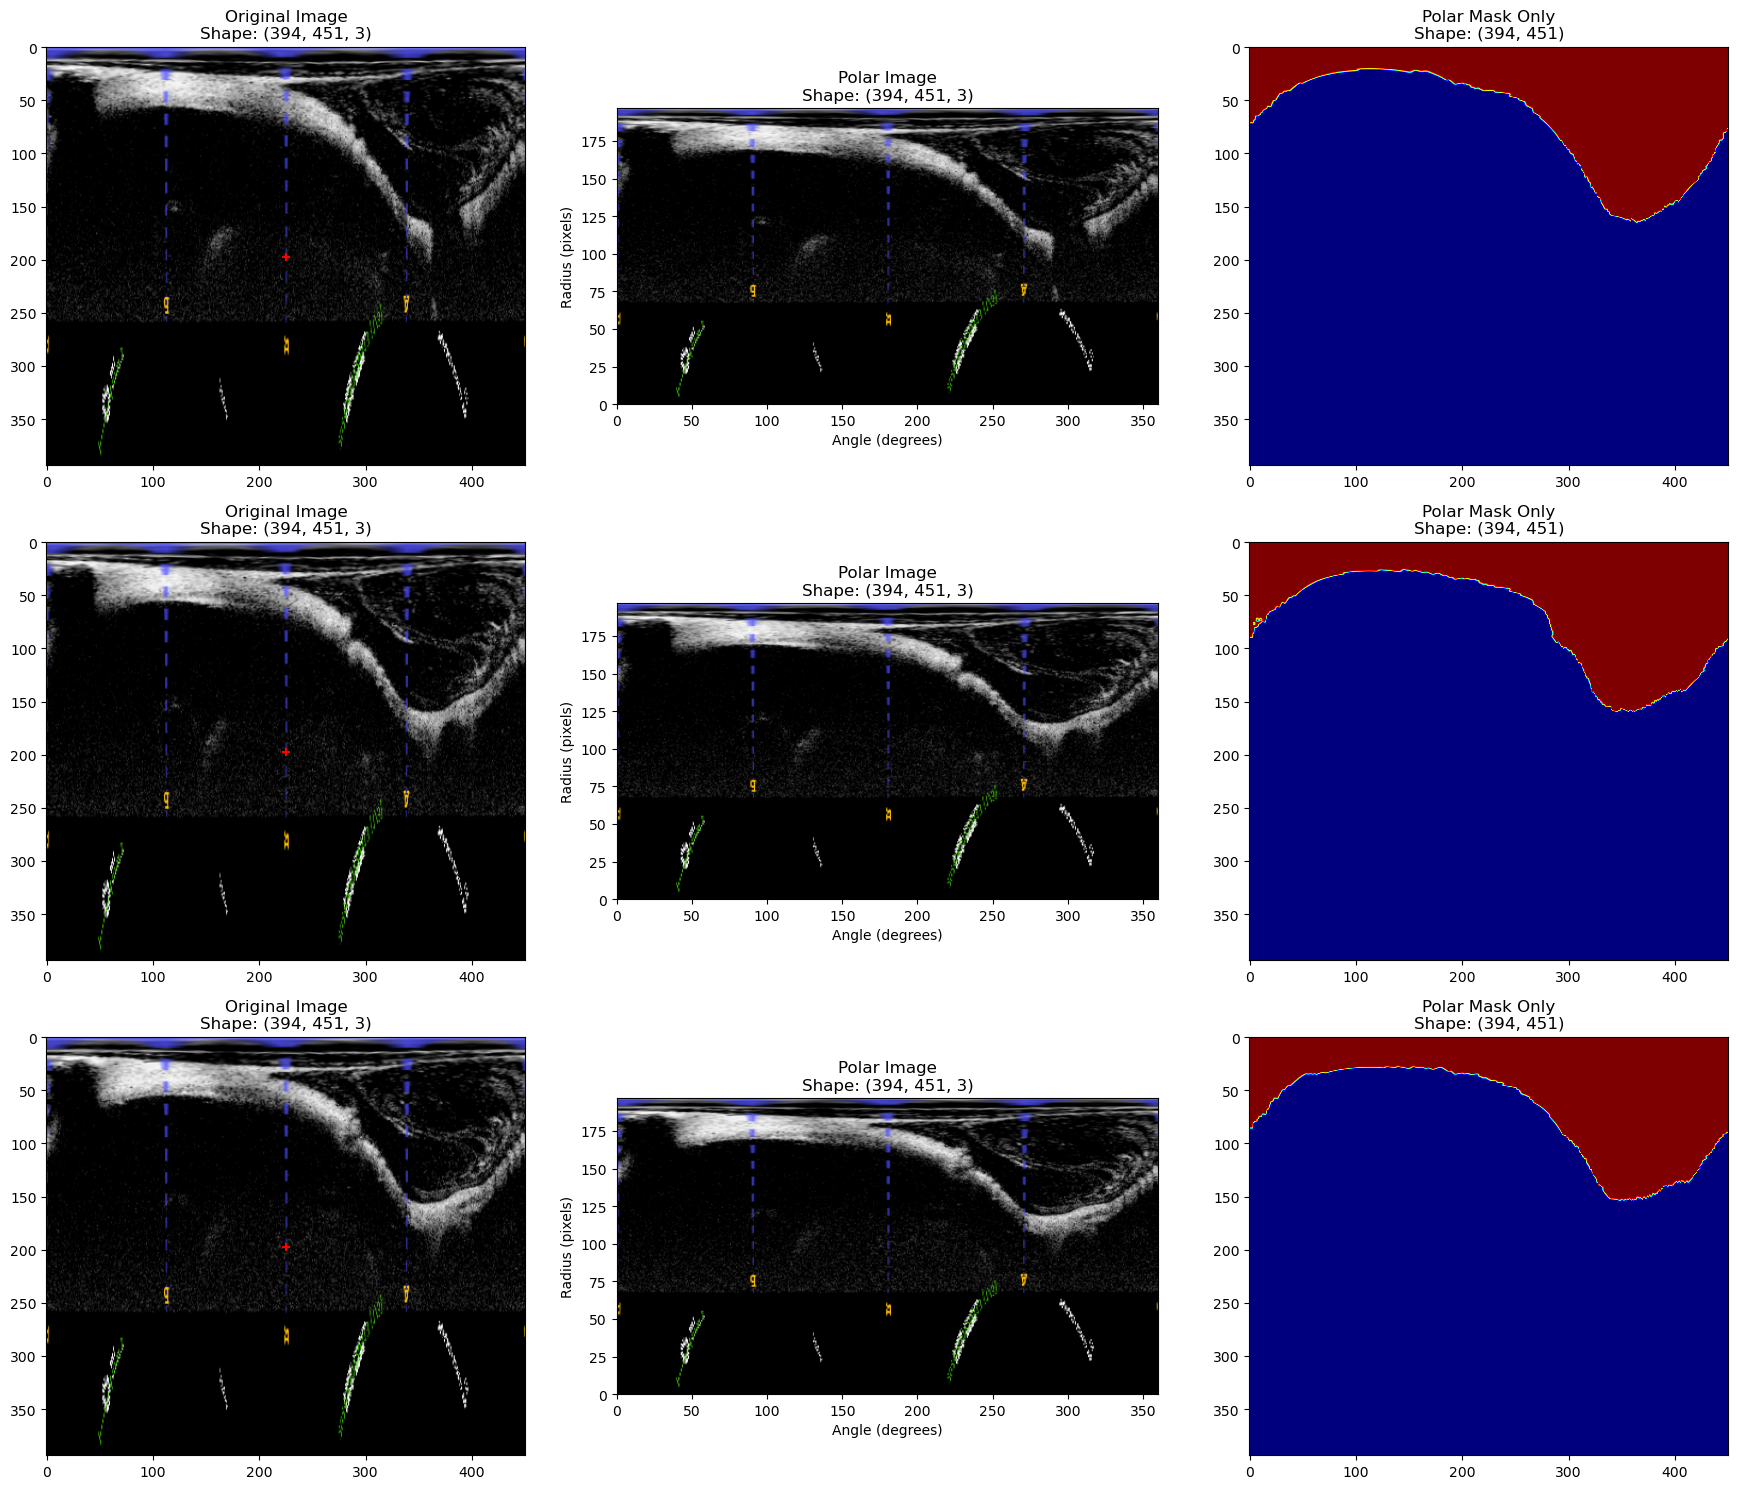

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from utils.data_loading import *
import torch
import torch.utils.data

def visualize_polar_transform(dataset, num_samples=3):
    """
    可视化极坐标转换效果（仅显示mask）
    - 显示各图像形状
    - 直接输出mask不叠加
    """
    fig, axs = plt.subplots(num_samples, 3, figsize=(18, 5*num_samples))

    for i in range(num_samples):
        sample = dataset[i]

        # 原始图像 + 中心点标记
        img = sample['image'].permute(1, 2, 0).numpy().squeeze()
        print(f"样本 {i} - 原始图像形状: {img.shape}")
        axs[i,0].imshow(img, cmap='gray')
        axs[i,0].scatter(dataset.polar_center[0], dataset.polar_center[1],
                        c='red', s=40, marker='+', label='Center')
        axs[i,0].set_title(f'Original Image\nShape: {img.shape}')


        # 极坐标展开图像
        polar_img = sample['image'].permute(1, 2, 0).numpy().squeeze()
        print(f"样本 {i} - 极坐标图像形状: {polar_img.shape}")
        axs[i,1].imshow(polar_img, cmap='gray', extent=[0, 360, 0, dataset.polar_max_radius])
        axs[i,1].set_xlabel('Angle (degrees)')
        axs[i,1].set_ylabel('Radius (pixels)')
        axs[i,1].set_title(f'Polar Image\nShape: {polar_img.shape}')

        # 直接显示mask（不叠加）
        mask = sample['mask'].numpy().squeeze()
        print(f"样本 {i} - Mask形状: {mask.shape}")

        # 显示纯mask图像
        axs[i,2].imshow(mask, cmap='jet')
        axs[i,2].set_title(f'Polar Mask Only\nShape: {mask.shape}')

        # 测试数据闭环验证
        """
        polar_mask = torch.from_numpy(mask).float()  # 关键修改：添加.float()
        polar_mask = cartesian_to_polar(polar_mask)
        print(f"样本 {i} - polar_mask形状: {polar_mask.shape}")

        # 显示极坐标mask图像
        axs[i,3].imshow(polar_mask, cmap='jet')
        axs[i,3].set_title(f'Polar Mask Only\nShape: {polar_mask.shape}')


        recovered_img = polar_to_cartesian(polar_mask,mask.shape[0],mask.shape[1])
        axs[i,4].imshow(recovered_img, cmap='jet')
        axs[i,4].set_title(f'Polar Mask Only\nShape: {recovered_img.shape}')
        """



    plt.tight_layout()
    plt.show()

# 初始化数据集（参数需根据实际图像调整）
dataset = BasicDatasetReverse(
    images_dir='test_img',
    mask_dir='test_mask',
    polar_center=(225, 197),    # 根据图像中心点调整
    polar_max_radius=197,       # 根据右下角1mm刻度估算
    polar_size=(360, 197)       # 展开为360度x197像素深度
)

# 可视化测试
visualize_polar_transform(dataset, num_samples=3)

In [3]:
#笛卡尔坐标系转极坐标系
import torch
import torch.nn.functional as F
import math

def cartesian_to_polar(img_tensor):
    input_shape = img_tensor.shape
    if img_tensor.dim() == 2:
        img_tensor = img_tensor.unsqueeze(0).unsqueeze(0)
    elif img_tensor.dim() == 3:
        img_tensor = img_tensor.unsqueeze(0)
    B, C, H, W = img_tensor.shape

    # 将尺寸转换为张量并保留设备信息
    W_tensor = torch.tensor(W - 1.0, dtype=img_tensor.dtype, device=img_tensor.device)
    H_tensor = torch.tensor(H - 1.0, dtype=img_tensor.dtype, device=img_tensor.device)

    cx = W_tensor / 2.0
    cy = H_tensor / 2.0
    R_max = torch.sqrt((W_tensor / 2.0)**2 + (H_tensor / 2.0)**2)

    i_polar = torch.linspace(0, H-1, H, device=img_tensor.device)
    j_polar = torch.linspace(0, W-1, W, device=img_tensor.device)
    i, j = torch.meshgrid(i_polar, j_polar, indexing='ij')

    r = (i / (H - 1)) * R_max  # 使用张量计算
    theta = j * (2 * math.pi) / W

    x = r * torch.cos(theta) + cx
    y = r * torch.sin(theta) + cy

    x_normalized = (x / (W - 1)) * 2 - 1
    y_normalized = (y / (H - 1)) * 2 - 1

    grid = torch.stack([x_normalized, y_normalized], dim=-1)
    grid = grid.unsqueeze(0).expand(B, H, W, 2)

    polar_tensor = F.grid_sample(img_tensor, grid, mode='bilinear', padding_mode='zeros', align_corners=True)

    if len(input_shape) == 2:
        polar_tensor = polar_tensor.squeeze(0).squeeze(0)
    elif len(input_shape) == 3:
        polar_tensor = polar_tensor.squeeze(0)
    return polar_tensor

In [4]:
#极坐标系转笛卡尔坐标系
def polar_to_cartesian(polar_tensor, target_h, target_w):
    input_shape = polar_tensor.shape
    if polar_tensor.dim() == 2:
        polar_tensor = polar_tensor.unsqueeze(0).unsqueeze(0)
    elif polar_tensor.dim() == 3:
        polar_tensor = polar_tensor.unsqueeze(0)
    B, C, H_polar, W_polar = polar_tensor.shape

    # 将目标尺寸转换为张量
    target_w_tensor = torch.tensor(target_w - 1.0, dtype=torch.float32, device=polar_tensor.device)
    target_h_tensor = torch.tensor(target_h - 1.0, dtype=torch.float32, device=polar_tensor.device)
    R_max_target = torch.sqrt((target_w_tensor / 2.0)**2 + (target_h_tensor / 2.0)**2)

    x_cart = torch.linspace(0, target_w-1, target_w, device=polar_tensor.device)
    y_cart = torch.linspace(0, target_h-1, target_h, device=polar_tensor.device)
    x, y = torch.meshgrid(x_cart, y_cart, indexing='xy')

    dx = x - (target_w_tensor / 2.0)
    dy = y - (target_h_tensor / 2.0)

    r = torch.sqrt(dx**2 + dy**2)
    theta = torch.atan2(dy, dx) % (2 * math.pi)

    i_polar = (r / R_max_target) * (H_polar - 1)
    j_polar = theta * W_polar / (2 * math.pi)

    i_normalized = (i_polar / (H_polar - 1)) * 2 - 1
    j_normalized = (j_polar / (W_polar - 1)) * 2 - 1

    grid = torch.stack([j_normalized, i_normalized], dim=-1)
    grid = grid.unsqueeze(0).expand(B, target_h, target_w, 2)

    cart_tensor = F.grid_sample(polar_tensor, grid, mode='bilinear', padding_mode='zeros', align_corners=True)

    if len(input_shape) == 2:
        cart_tensor = cart_tensor.squeeze(0).squeeze(0)
    elif len(input_shape) == 3:
        cart_tensor = cart_tensor.squeeze(0)
    return cart_tensor

torch.Size([3, 256, 256]) torch.Size([3, 256, 256]) torch.Size([3, 256, 256])


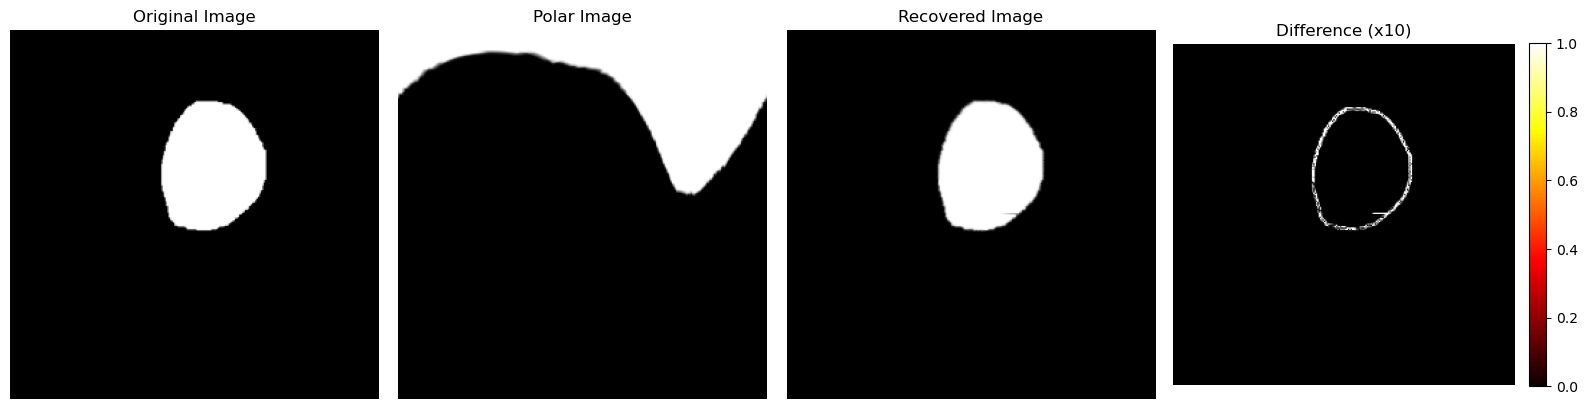

In [7]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def test_transform_with_visualization():
    # 读取真实图片
    img_path = "test_mask/0313_axial0127.png"  # 请替换为你的图片路径
    original_img = Image.open(img_path).convert('RGB')

    # 调整尺寸并转为Tensor
    H, W = 256, 256
    img_tensor = torch.from_numpy(np.array(original_img.resize((W, H)))).float()
    img_tensor = img_tensor.permute(2, 0, 1) / 255.0  # [C, H, W]格式，范围[0,1]

    # 执行坐标转换
    polar_img = cartesian_to_polar(img_tensor)
    recovered_img = polar_to_cartesian(polar_img, H, W)
    print(img_tensor.shape,polar_img.shape,recovered_img.shape)

    # 计算差异
    diff = torch.abs(img_tensor - recovered_img)

    # 创建画布
    plt.figure(figsize=(16, 4))

    # 显示原始图像
    plt.subplot(141)
    plt.imshow(img_tensor.permute(1, 2, 0).numpy())
    plt.title("Original Image")
    plt.axis('off')

    # 显示极坐标图像
    plt.subplot(142)
    polar_display = polar_img.permute(1, 2, 0).numpy()
    plt.imshow(np.clip(polar_display, 0, 1))
    plt.title("Polar Image")
    plt.axis('off')

    # 显示恢复后的图像
    plt.subplot(143)
    recovered_display = recovered_img.permute(1, 2, 0).numpy()
    plt.imshow(np.clip(recovered_display, 0, 1))
    plt.title("Recovered Image")
    plt.axis('off')

    # 显示差异图（放大10倍便于观察）
    plt.subplot(144)
    diff_display = diff.permute(1, 2, 0).numpy() * 10
    im = plt.imshow(np.clip(diff_display, 0, 1), cmap='hot')
    plt.title("Difference (x10)")
    plt.axis('off')
    plt.colorbar(im, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

# 执行测试
test_transform_with_visualization()

In [4]:
import os
import shutil
from pathlib import Path

def move_last_10_percent(src_img_dir, src_mask_dir, dst_img_dir, dst_mask_dir):
    # 创建目标文件夹
    dst_img_dir.mkdir(parents=True, exist_ok=True)
    dst_mask_dir.mkdir(parents=True, exist_ok=True)

    # 获取所有图像文件（不排序，保持原始顺序）
    img_files = [f for f in os.listdir(src_img_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.tif'))]
    total = len(img_files)
    num_val = int(total * 0.1)

    # 移动最后10%的文件
    for img_file in img_files[-num_val:]:
        # 移动图像
        src_img = src_img_dir / img_file
        dst_img = dst_img_dir / img_file
        shutil.move(str(src_img), str(dst_img))

        # 移动对应的掩码（假设同名）
        mask_file = img_file  # 如果扩展名不同，可以在这里修改
        src_mask = src_mask_dir / mask_file
        if src_mask.exists():
            shutil.move(str(src_mask), str(dst_mask_dir / mask_file))
        else:
            print(f"Warning: Missing mask for {img_file}")


# 设置路径（根据实际情况修改）
dir_img = Path('./data/imgs/')
dir_mask = Path('./data/masks/')
val_img_dir = Path('./data/val_imgs/')
val_mask_dir = Path('./data/val_masks/')

move_last_10_percent(dir_img, dir_mask, val_img_dir, val_mask_dir)
print(f"文件移动完成，前{len(os.listdir(dir_img))}个保留训练，后{len(os.listdir(val_img_dir))}个用于验证")

文件移动完成，前1965个保留训练，后218个用于验证


In [ ]:
class FullDoubleCoordAttUNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(FullDoubleCoordAttUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.cartesian_to_polar = cartesian_to_polar#  笛卡尔系转极坐标系
        self.polar_to_cartesian = polar_to_cartesian # 极坐标系转笛卡尔坐标系


        self.inc_cartesian = (DoubleConv(n_channels, 64))
        self.down_cartesian1 = (Down(64, 128))
        self.down_cartesian2 = (Down(128, 256))
        self.down_cartesian3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down_cartesian4 = (Down(512, 1024 // factor))
        self.up_cartesian1 = (Up(1024, 512 // factor, bilinear))
        self.up_cartesian2 = (Up(512, 256 // factor, bilinear))
        self.up_cartesian3 = (Up(256, 128 // factor, bilinear))
        self.up_cartesian4 = (Up(128, 64, bilinear))
        self.out_cartesian_c = (OutConv(64, n_classes))

        self.inc_polar = (DoubleConv(n_channels, 64))
        self.down_polar1 = (Down(64, 128))
        self.down_polar2 = (Down(128, 256))
        self.down_polar3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down_polar4 = (Down(512, 1024 // factor))
        self.up_polar1 = (Up(1024, 512 // factor, bilinear))
        self.up_polar2 = (Up(512, 256 // factor, bilinear))
        self.up_polar3 = (Up(256, 128 // factor, bilinear))
        self.up_polar4 = (Up(128, 64, bilinear))
        self.out_polar_c = (OutConv(64, n_classes))

        #双特征图注意力
        self.coord_att1 = DoubleCoordAtt(inp=64, oup=64)
        self.coord_att2 = DoubleCoordAtt(inp=128, oup=128)
        self.coord_att3 = DoubleCoordAtt(inp=256, oup=256)
        self.coord_att4 = DoubleCoordAtt(inp=512, oup=512)
        self.coord_att5 = DoubleCoordAtt(inp=1024, oup=1024)

        # Decoder部分的双坐标注意力模块
        self.coord_att_up1 = DoubleCoordAtt(inp=512 // factor, oup=512 // factor)  # 对应up1层
        self.coord_att_up2 = DoubleCoordAtt(inp=256 // factor, oup=256 // factor)  # 对应up2层
        self.coord_att_up3 = DoubleCoordAtt(inp=128 // factor, oup=128 // factor)  # 对应up3层
        self.coord_att_up4 = DoubleCoordAtt(inp=64, oup=64)  # 对应up4层

        self.merge = nn.Conv2d(2*n_classes, n_classes, 3, padding=1)

    def forward(self, x):
        x_cartesian = x
        x_polar = x

        #笛卡尔坐标系下采样 和 极坐标坐标系下采样
        x1_cartesian = self.inc_cartesian(x_cartesian)
        x_polar = self.cartesian_to_polar(x_polar)
        x1_polar = self.inc_polar(x_polar)
        t_cartesian, t_polar = self.coord_att1(x1_cartesian, x1_polar)
        x1_cartesian, x1_polar = t_cartesian+x1_cartesian, t_polar+x1_polar

        x2_cartesian = self.down_cartesian1(x1_cartesian)
        x2_polar = self.down_polar1(x1_polar)
        t_cartesian, t_polar = self.coord_att2(x2_cartesian, x2_polar)
        x2_cartesian, x2_polar = t_cartesian + x2_cartesian, t_polar + x2_polar


        x3_cartesian = self.down_cartesian2(x2_cartesian)
        x3_polar = self.down_polar2(x2_polar)
        t_cartesian, t_polar = self.coord_att3(x3_cartesian, x3_polar)
        x3_cartesian, x3_polar = t_cartesian + x3_cartesian, t_polar + x3_polar

        x4_cartesian = self.down_cartesian3(x3_cartesian)
        x4_polar = self.down_polar3(x3_polar)
        t_cartesian, t_polar = self.coord_att4(x4_cartesian, x4_polar)
        x4_cartesian, x4_polar = t_cartesian + x4_cartesian, t_polar + x4_polar

        x5_cartesian = self.down_cartesian4(x4_cartesian)
        x5_polar = self.down_polar4(x4_polar)
        t_cartesian, t_polar = self.coord_att5(x5_cartesian, x5_polar)
        x5_cartesian, x5_polar = t_cartesian + x5_cartesian, t_polar + x5_polar

        # ====================== 修正后的Decoder部分 ======================
        # 初始化解码器特征
        d_cartesian = x5_cartesian  # 编码器最后一层输出 [1024, H/16, W/16]
        d_polar = x5_polar

        # 定义各层的跳跃连接引用
        skip_connections_cartesian = [x4_cartesian, x3_cartesian, x2_cartesian, x1_cartesian]
        skip_connections_polar = [x4_polar, x3_polar, x2_polar, x1_polar]

        # 按层次处理解码过程（从深层到浅层）
        for layer_idx in range(4):
            # 上采样操作 ------------------------------------------------
            up_layer = getattr(self, f'up_cartesian{layer_idx + 1}')
            skip_cart = skip_connections_cartesian[3 - layer_idx]  # 倒序取跳跃连接
            d_cartesian = up_layer(d_cartesian, skip_cart)

            up_polar_layer = getattr(self, f'up_polar{layer_idx + 1}')
            skip_polar = skip_connections_polar[3 - layer_idx]
            d_polar = up_polar_layer(d_polar, skip_polar)

            # 注意力交互 ------------------------------------------------
            # 保存原始特征用于残差连接
            original_cart = d_cartesian.clone().detach()
            original_polar = d_polar.clone().detach()

            # 应用双路径注意力
            att_layer = getattr(self, f'coord_att_up{layer_idx + 1}')
            att_cart, att_polar = att_layer(d_cartesian, d_polar)

            # 残差连接（注意力输出 + 原始上采样输出）
            d_cartesian = att_cart + original_cart
            d_polar = att_polar + original_polar

        # ==================== 最终输出部分 ====================
        # 笛卡尔路径最终输出
        logits_cartesian = self.out_cartesian_c(d_cartesian)

        # 极坐标路径处理
        logits_polar = self.out_polar_c(d_polar)
        logits_polar = self.polar_to_cartesian(
            logits_polar,
            target_height=logits_cartesian.shape[2],  # 保持与笛卡尔输出尺寸一致
            target_width=logits_cartesian.shape[3]
        )

        # 特征融合
        combined = torch.cat([logits_cartesian, logits_polar], dim=1)
        final_mask = self.merge(combined)

        return final_mask

    def use_checkpointing(self):
        """启用双路径检查点机制，节省显存"""
        # 笛卡尔路径编码器
        self.inc_cartesian = torch.utils.checkpoint(self.inc_cartesian)
        self.down_cartesian1 = torch.utils.checkpoint(self.down_cartesian1)
        self.down_cartesian2 = torch.utils.checkpoint(self.down_cartesian2)
        self.down_cartesian3 = torch.utils.checkpoint(self.down_cartesian3)
        self.down_cartesian4 = torch.utils.checkpoint(self.down_cartesian4)

        # 笛卡尔路径解码器
        self.up_cartesian1 = torch.utils.checkpoint(self.up_cartesian1)
        self.up_cartesian2 = torch.utils.checkpoint(self.up_cartesian2)
        self.up_cartesian3 = torch.utils.checkpoint(self.up_cartesian3)
        self.up_cartesian4 = torch.utils.checkpoint(self.up_cartesian4)
        self.out_cartesian_c = torch.utils.checkpoint(self.out_cartesian_c)

        # 极坐标路径编码器
        self.inc_polar = torch.utils.checkpoint(self.inc_polar)
        self.down_polar1 = torch.utils.checkpoint(self.down_polar1)
        self.down_polar2 = torch.utils.checkpoint(self.down_polar2)
        self.down_polar3 = torch.utils.checkpoint(self.down_polar3)
        self.down_polar4 = torch.utils.checkpoint(self.down_polar4)

        # 极坐标路径解码器
        self.up_polar1 = torch.utils.checkpoint(self.up_polar1)
        self.up_polar2 = torch.utils.checkpoint(self.up_polar2)
        self.up_polar3 = torch.utils.checkpoint(self.up_polar3)
        self.up_polar4 = torch.utils.checkpoint(self.up_polar4)
        self.out_polar_c = torch.utils.checkpoint(self.out_polar_c)

        self.coord_att1 = torch.utils.checkpoint(self.coord_att1)
        self.coord_att2 = torch.utils.checkpoint(self.coord_att2)
        self.coord_att3 = torch.utils.checkpoint(self.coord_att3)
        self.coord_att4 = torch.utils.checkpoint(self.coord_att4)
        self.coord_att5 = torch.utils.checkpoint(self.coord_att5)

        self.coord_att_up1 = torch.utils.checkpoint(self.coord_att_up1)
        self.coord_att_up2 = torch.utils.checkpoint(self.coord_att_up2)
        self.coord_att_up3 = torch.utils.checkpoint(self.coord_att_up3)
        self.coord_att_up4 = torch.utils.checkpoint(self.coord_att_up4)